In [1]:
import ultralytics
print(ultralytics.__version__)

8.2.49


In [3]:
import torch
import torchvision
from torchvision import models
from torchvision.transforms import functional as FT
from torchvision.transforms import transforms as T
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, Subset
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

In [4]:
# Define albumentations
def get_albumentation(train):
    if train:
        return A.Compose([
            A.Resize(500,500),
            A.HorizontalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
            A.Resize(300, 300),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


In [9]:
# Define dataset path
dataset_path = 'D:/summer_intern/Dataset/UTDAC2020/UTDAC2020'
annotation_train = os.path.join(dataset_path, 'annotations', 'instances_train2017_waterweeds.json')
annotation_val = os.path.join(dataset_path, 'annotations', 'instances_val2017_waterweeds.json')


In [10]:
def find_unique_classes_and_count(annotation_file):
    coco = COCO(annotation_file)
    categories = coco.loadCats(coco.getCatIds())
    category_dict = {cat['id']: cat['name'] for cat in categories}
    return category_dict, len(category_dict)

# Example usage:
classes, n_classes = find_unique_classes_and_count(annotation_train)

print(f"Unique classes and their IDs: {classes}")
print(f"Number of unique classes: {n_classes}")

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
Unique classes and their IDs: {1: 'echinus', 2: 'starfish', 3: 'holothurian', 4: 'scallop', 5: 'waterweeds'}
Number of unique classes: 5


In [11]:
class_id_map = {original_id: new_id for new_id, original_id in enumerate(classes)}

In [13]:
from torchvision import datasets
class UTDACDetectionYOLO(datasets.VisionDataset):
    def __init__(self, root, annotation_file, transforms=None):
        super(UTDACDetectionYOLO, self).__init__(root, transforms=transforms)
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation_file)  # Load COCO annotations

        # Load image ids
        self.img_ids = self.coco.getImgIds()
        self.imgs = [self.coco.loadImgs(img_id)[0]['file_name'] for img_id in self.img_ids]

    def __getitem__(self, idx):
        # Get image id
        img_id = self.img_ids[idx]

        # Load image
        img_path = os.path.join(self.root, self.imgs[idx])
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        height, width, _ = img.shape

        # Load annotations for the image
        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)
        
        boxes = []
        labels = []
        for ann in anns:
            bbox = ann['bbox']
            # Convert bbox from [x, y, width, height] to [x_min, y_min, x_max, y_max]
            x_min = bbox[0]
            y_min = bbox[1]
            x_max = bbox[0] + bbox[2]
            y_max = bbox[1] + bbox[3]
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(class_id_map[ann['category_id']])  # Map original class ID to new class ID

        # Correct invalid bounding boxes
        corrected_boxes = []
        for bbox in boxes:
            x_min, y_min, x_max, y_max = bbox
            if x_max <= x_min:
                x_min, x_max = x_max, x_min
            if y_max <= y_min:
                y_min, y_max = y_max, y_min
            corrected_boxes.append([x_min, y_min, x_max, y_max])
        
        boxesYOLO = []
        for bbox in corrected_boxes:
            # Convert to YOLO format
            x_min, y_min, x_max, y_max = bbox
            x_center = (x_min + x_max) / 2 / width
            y_center = (y_min + y_max) / 2 / height
            box_width = (x_max - x_min) / width
            box_height = (y_max - y_min) / height
            boxesYOLO.append([x_center, y_center, box_width, box_height])
            
        # Convert to tensors
        boxes = torch.tensor(boxesYOLO, dtype=torch.float32).clone().detach()
        labels = torch.tensor(labels, dtype=torch.int64).clone().detach()

        # Create target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": torch.tensor([ann['area'] for ann in anns]),
            "iscrowd": torch.tensor([ann['iscrowd'] for ann in anns])
        }

        # Apply transformations
        if self.transforms is not None:
            transformed = self.transforms(image=img_rgb, bboxes=target['boxes'], labels=labels)
            img_rgb = transformed['image']
            target['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32).clone().detach()

        return img_rgb, target
    def __len__(self):
        return len(self.imgs)



In [14]:
import os
train_dataset = UTDACDetectionYOLO(root=os.path.join(dataset_path, 'Filtered_images_2'), annotation_file=annotation_train)


loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


In [15]:
img, target = train_dataset[1]

In [16]:
target

{'boxes': tensor([[0.2863, 0.5299, 0.0268, 0.0505],
         [0.3738, 0.3894, 0.0247, 0.0407]]),
 'labels': tensor([0, 0]),
 'image_id': tensor([1]),
 'area': tensor([11440,  8544]),
 'iscrowd': tensor([0, 0])}

In [17]:
len(train_dataset)

5168

In [23]:
val_dataset=UTDACDetectionYOLO(root=os.path.join(dataset_path,'Filtered_images_val'),annotation_file=annotation_val)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [18]:
def convert_to_yolo_format(target):
    boxes = target['boxes']
    labels = target['labels']
    image_id = target['image_id'].item()

    yolo_boxes = []
    for i, box in enumerate(boxes):
        x_center, y_center, width, height = box
        label = labels[i].item()
        yolo_boxes.append(f"{label} {x_center} {y_center} {width} {height}")
    
    return yolo_boxes, image_id

In [24]:
def save_yolo_annotations(yolo_boxes,file_name, output_dir):
    labels_dir = os.path.join(output_dir, "val")
    os.makedirs(labels_dir, exist_ok=True)
   
    # Remove the extension from the file name to get the base name
   
    # Remove the extension from the file name to get the base name
    base_name = os.path.splitext(file_name)[0]
    txt_file_path = os.path.join(labels_dir, f"{base_name}.txt")
    
    with open(txt_file_path, 'w') as f:
        for box in yolo_boxes:
            f.write(f"{box}\n")

In [27]:
import json
Label_dir=os.path.join(dataset_path, 'labels')
with open(annotation_val, 'r') as file:
        data = json.load(file)
for image, target in val_dataset:
    yolo_boxes, image_id = convert_to_yolo_format(target)
    file_name = next((img['file_name'] for img in data['images'] if img['id'] == image_id), None)
    if file_name:
        save_yolo_annotations(yolo_boxes, file_name, Label_dir)
    else:
        print(f"No matching file_name found for image_id {image_id}")
    

print("YOLO annotation saving completed.")    

YOLO annotation saving completed.


In [36]:
class CFG:
    DEBUG = False
    
    SEED = 1

    # classes
    NUM_CLASSES = 5
    CLASSES = ['echinus', 'starfish', 'holothurian', 'scallop', 'waterweeds']

    # training
    EPOCHS = 25
    BATCH_SIZE = 16
    
    BASE_MODEL = 'yolov8n'  # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto'  # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 0.001
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = 'D:/summer_intern/Dataset/UTDAC2020/UTDAC2020'
    
    OUTPUT_DIR = 'D:/summer_intern/Dataset/UTDAC2020/UTDAC2020'

In [37]:
import ultralytics
print(ultralytics.__version__)

8.2.49


In [38]:
from ultralytics import YOLO

In [39]:
import yaml
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'val'),
    
    'nc': CFG.NUM_CLASSES,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [40]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- echinus
- starfish
- holothurian
- scallop
- waterweeds
nc: 5
train: D:/summer_intern/Dataset/UTDAC2020/UTDAC2020\train
val: D:/summer_intern/Dataset/UTDAC2020/UTDAC2020\val



In [42]:
import pandas as pd
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES)}

# Initialize dictionaries to store statistics
class_stat = {}
data_len = {}
class_info = []

# Iterate over dataset modes
for mode in ['train', 'val']:
    # Initialize class count for the current mode
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES)}
    
    # Path to the labels directory for the current mode
    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode,'labels')
    
    # Iterate over label files in the directory
    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()
            
            # Increment the count for each unique class in the file
            for cls in set([line.split()[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    # Store data length and class count statistics
    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count
    
    # Append information for the current mode
    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

# Create a DataFrame to store the statistics
dataset_stats_df = pd.DataFrame(class_info)
print(dataset_stats_df)

    Mode  echinus  starfish  holothurian  scallop  waterweeds  Data_Volume
0  train     1892      1208         1171      830          10         2584
1    val      465       283          288      221           2          646


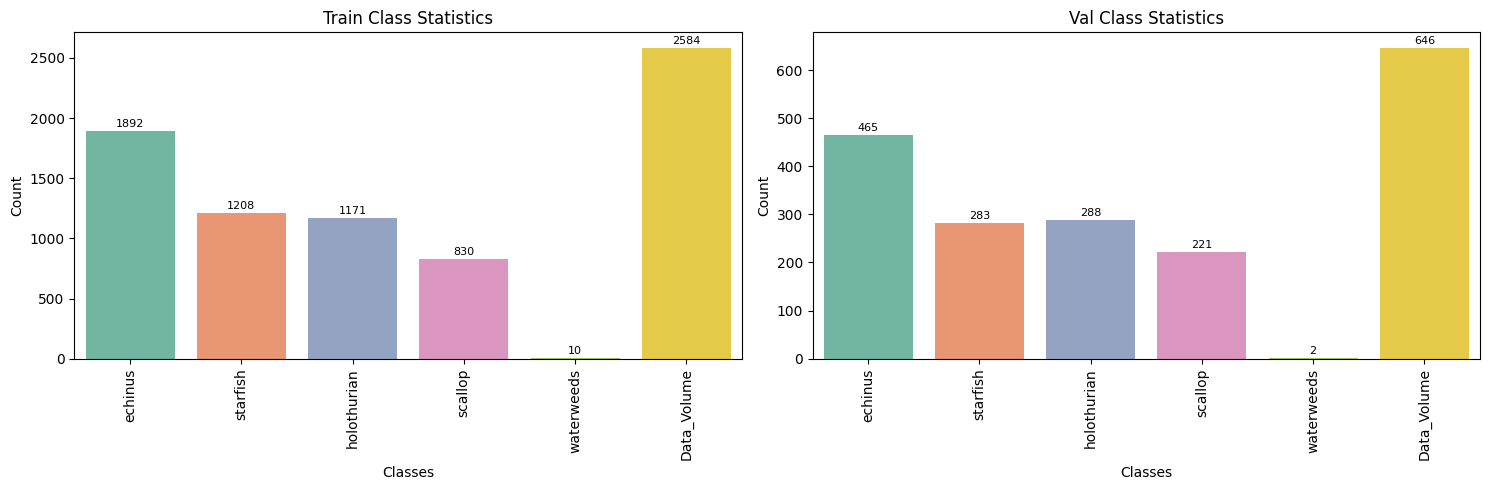

In [43]:

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming dataset_stats_df is already created

# Create subplots with 1 row and 2 columns for 'train' and 'val'
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'val']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()


In [44]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov8n.pt
Epochs:  25
Batch:  16


In [45]:

img_properties = {
    'height': 500,
    'width': 500
}

In [47]:
# Load the model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

100%|██████████| 6.25M/6.25M [01:12<00:00, 90.5kB/s]


In [48]:
results = model.train(
    data=os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    epochs=CFG.EPOCHS,
    batch=CFG.BATCH_SIZE,
    optimizer=CFG.OPTIMIZER,
    lr0=CFG.LR,
    lrf=CFG.LR_FACTOR,
    imgsz=(img_properties['height'], img_properties['width']),
    seed=CFG.SEED,
    
    workers=4,
    name=CFG.EXP_NAME,
   
)


Ultralytics YOLOv8.2.49  Python-3.11.3 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i5-11320H 3.20GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:/summer_intern/Dataset/UTDAC2020/UTDAC2020\data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=(500, 500), save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=ppe_css_25_epochs, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=1, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=

train: Scanning D:\summer_intern\Dataset\UTDAC2020\UTDAC2020\train\labels... 2584 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2584/2584 [00:02<00:00, 936.11it/s]

train: WARNING  D:\summer_intern\Dataset\UTDAC2020\UTDAC2020\train\images\000508.jpg: 1 duplicate labels removed


train: New cache created: D:\summer_intern\Dataset\UTDAC2020\UTDAC2020\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning D:\summer_intern\Dataset\UTDAC2020\UTDAC2020\val\labels... 646 images, 0 backgrounds, 0 corrupt: 100%|██████████| 646/646 [00:00<00:00, 919.33it/s]

val: New cache created: D:\summer_intern\Dataset\UTDAC2020\UTDAC2020\val\labels.cache
Plotting labels to runs\detect\ppe_css_25_epochs\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs\detect\ppe_css_25_epochs
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25         0G      1.994      2.544      1.307        127        512: 100%|██████████| 162/162 [21:21<00:00,  7.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:41<00:00,  4.83s/it]

                   all        646       5655      0.684       0.31      0.343      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25         0G      1.814      1.593      1.199         77        512: 100%|██████████| 162/162 [21:16<00:00,  7.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [02:54<00:00,  8.32s/it]

                   all        646       5655      0.697      0.367      0.398      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25         0G      1.778      1.479      1.191        138        512: 100%|██████████| 162/162 [32:05<00:00, 11.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [03:29<00:00,  9.96s/it]

                   all        646       5655      0.452      0.415       0.42      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25         0G      1.745      1.413      1.169         99        512: 100%|██████████| 162/162 [32:33<00:00, 12.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [02:52<00:00,  8.21s/it]

                   all        646       5655      0.499       0.46      0.475      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25         0G      1.729      1.347      1.159        100        512: 100%|██████████| 162/162 [31:25<00:00, 11.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [03:30<00:00, 10.03s/it]

                   all        646       5655       0.54      0.456      0.503      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25         0G      1.673       1.26      1.143        123        512: 100%|██████████| 162/162 [27:59<00:00, 10.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:42<00:00,  4.87s/it]

                   all        646       5655      0.743      0.454      0.514      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25         0G      1.686      1.254      1.141        111        512: 100%|██████████| 162/162 [19:48<00:00,  7.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.71s/it]

                   all        646       5655      0.756      0.485      0.532      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25         0G      1.656      1.214       1.13        104        512: 100%|██████████| 162/162 [19:35<00:00,  7.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.67s/it]

                   all        646       5655      0.779       0.48      0.535      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25         0G      1.653      1.183      1.124        137        512: 100%|██████████| 162/162 [21:28<00:00,  7.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:39<00:00,  4.73s/it]

                   all        646       5655      0.578      0.501      0.559      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25         0G      1.619      1.153      1.119        139        512: 100%|██████████| 162/162 [19:46<00:00,  7.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.70s/it]

                   all        646       5655       0.79      0.503      0.555      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25         0G      1.615      1.138      1.114        194        512: 100%|██████████| 162/162 [25:24<00:00,  9.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [02:41<00:00,  7.70s/it]

                   all        646       5655      0.792      0.511      0.584      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25         0G      1.605      1.106      1.107         80        512: 100%|██████████| 162/162 [21:59<00:00,  8.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.69s/it]

                   all        646       5655        0.8      0.514      0.585      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25         0G      1.583      1.082      1.099        144        512: 100%|██████████| 162/162 [19:35<00:00,  7.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:39<00:00,  4.72s/it]

                   all        646       5655      0.806      0.522      0.585      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25         0G      1.583      1.068        1.1        122        512: 100%|██████████| 162/162 [19:30<00:00,  7.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.68s/it]

                   all        646       5655        0.8      0.522      0.684      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25         0G      1.559      1.056      1.095        190        512: 100%|██████████| 162/162 [19:29<00:00,  7.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.67s/it]

                   all        646       5655      0.699      0.581       0.68      0.349


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25         0G       1.55      1.047      1.106         93        512: 100%|██████████| 162/162 [19:18<00:00,  7.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:41<00:00,  4.85s/it]

                   all        646       5655       0.81      0.515      0.631      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25         0G      1.536      1.008      1.098         23        512: 100%|██████████| 162/162 [19:01<00:00,  7.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.68s/it]

                   all        646       5655      0.615      0.527      0.589      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25         0G      1.527     0.9929      1.094         64        512: 100%|██████████| 162/162 [18:56<00:00,  7.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:37<00:00,  4.66s/it]

                   all        646       5655      0.822      0.519       0.59      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25         0G      1.508      0.961      1.087         90        512: 100%|██████████| 162/162 [18:57<00:00,  7.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.68s/it]

                   all        646       5655      0.833      0.529      0.594      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25         0G      1.501     0.9493      1.081         96        512: 100%|██████████| 162/162 [18:57<00:00,  7.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.70s/it]

                   all        646       5655      0.646      0.669      0.655      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25         0G      1.491     0.9255      1.076         63        512: 100%|██████████| 162/162 [18:57<00:00,  7.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.67s/it]

                   all        646       5655      0.825      0.542      0.634      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25         0G       1.47     0.9085      1.071         58        512: 100%|██████████| 162/162 [19:01<00:00,  7.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.69s/it]

                   all        646       5655      0.632      0.552       0.62      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25         0G      1.454     0.8925      1.067         61        512: 100%|██████████| 162/162 [19:00<00:00,  7.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.68s/it]

                   all        646       5655      0.838      0.545      0.622       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25         0G      1.448     0.8789      1.063         48        512: 100%|██████████| 162/162 [18:56<00:00,  7.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.68s/it]

                   all        646       5655       0.81      0.562      0.719      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25         0G      1.432     0.8601      1.057         51        512: 100%|██████████| 162/162 [18:57<00:00,  7.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.68s/it]

                   all        646       5655      0.829      0.625      0.723      0.441



25 epochs completed in 9.870 hours.
Optimizer stripped from runs\detect\ppe_css_25_epochs\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\ppe_css_25_epochs\weights\best.pt, 6.2MB

Validating runs\detect\ppe_css_25_epochs\weights\best.pt...
Ultralytics YOLOv8.2.49  Python-3.11.3 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i5-11320H 3.20GHz)
Model summary (fused): 168 layers, 3006623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:16<00:00,  3.65s/it]


                   all        646       5655      0.832      0.624      0.723      0.441
               echinus        465       2541      0.888      0.776      0.882      0.498
              starfish        283        810      0.875        0.7      0.824      0.479
           holothurian        288        834      0.806      0.525      0.652      0.336
               scallop        221       1468       0.83      0.617      0.761      0.445
            waterweeds          2          2      0.762        0.5      0.497      0.448
Speed: 1.5ms preprocess, 80.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\ppe_css_25_epochs


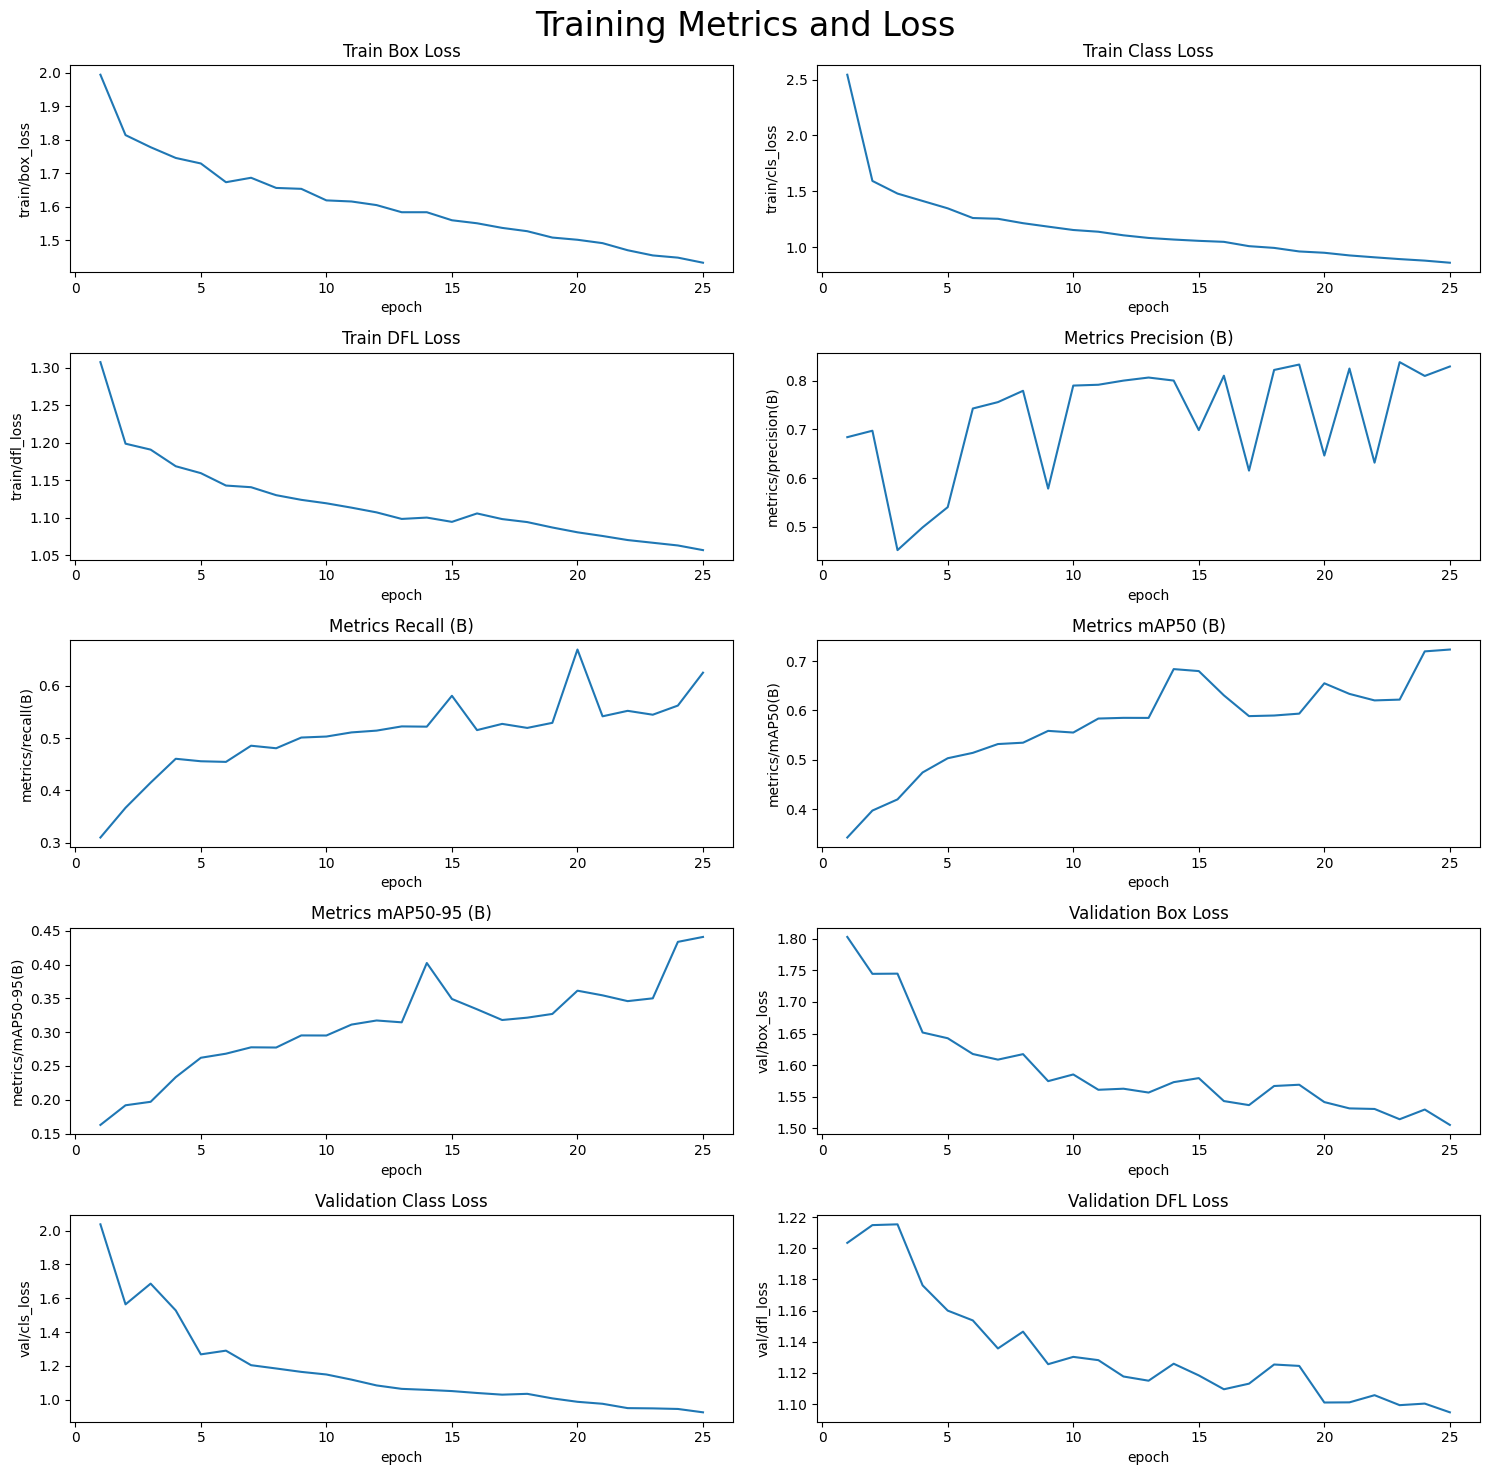

In [50]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('D:/summer_intern/Dataset/UTDAC2020/UTDAC2020/runs/detect/ppe_css_25_epochs/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

In [51]:
#retrain use model best.pt for another 25 epoch
model = YOLO('D:/summer_intern/Dataset/UTDAC2020/UTDAC2020/runs/detect/ppe_css_25_epochs/weights/best.pt')
results = model.train(
    data=os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    epochs=CFG.EPOCHS,
    batch=CFG.BATCH_SIZE,
    optimizer=CFG.OPTIMIZER,
    lr0=CFG.LR,
    lrf=CFG.LR_FACTOR,
    imgsz=(img_properties['height'], img_properties['width']),
    seed=CFG.SEED,
    
    workers=4,
    name=CFG.EXP_NAME,
   
)


Ultralytics YOLOv8.2.49  Python-3.11.3 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i5-11320H 3.20GHz)
engine\trainer: task=detect, mode=train, model=D:/summer_intern/Dataset/UTDAC2020/UTDAC2020/runs/detect/ppe_css_25_epochs/weights/best.pt, data=D:/summer_intern/Dataset/UTDAC2020/UTDAC2020\data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=(500, 500), save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=ppe_css_25_epochs2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=1, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_m

train: Scanning D:\summer_intern\Dataset\UTDAC2020\UTDAC2020\train\labels.cache... 2584 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2584/2584 [00:00<?, ?it/s]

train: WARNING  D:\summer_intern\Dataset\UTDAC2020\UTDAC2020\train\images\000508.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning D:\summer_intern\Dataset\UTDAC2020\UTDAC2020\val\labels.cache... 646 images, 0 backgrounds, 0 corrupt: 100%|██████████| 646/646 [00:00<?, ?it/s]

Plotting labels to runs\detect\ppe_css_25_epochs2\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs\detect\ppe_css_25_epochs2
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25         0G      1.512     0.9698      1.072        127        512: 100%|██████████| 162/162 [33:34<00:00, 12.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [03:27<00:00,  9.87s/it]

                   all        646       5655      0.814      0.541      0.597      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25         0G      1.548      1.012      1.083         77        512: 100%|██████████| 162/162 [33:29<00:00, 12.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [03:13<00:00,  9.21s/it]

                   all        646       5655       0.78      0.517      0.566      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25         0G       1.58      1.057        1.1        138        512: 100%|██████████| 162/162 [33:26<00:00, 12.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [02:59<00:00,  8.53s/it]

                   all        646       5655       0.78      0.526      0.576      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25         0G      1.574      1.043      1.097         99        512: 100%|██████████| 162/162 [19:55<00:00,  7.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:40<00:00,  4.77s/it]

                   all        646       5655      0.785      0.512      0.566      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25         0G      1.585      1.043      1.099        100        512: 100%|██████████| 162/162 [19:49<00:00,  7.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:39<00:00,  4.73s/it]

                   all        646       5655      0.792      0.519      0.589      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25         0G       1.55      1.012      1.091        123        512: 100%|██████████| 162/162 [19:49<00:00,  7.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:39<00:00,  4.73s/it]

                   all        646       5655      0.805      0.525      0.618      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25         0G      1.563      1.015      1.089        111        512: 100%|██████████| 162/162 [19:50<00:00,  7.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:39<00:00,  4.73s/it]

                   all        646       5655      0.815      0.526       0.69      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25         0G      1.545     0.9977      1.082        104        512: 100%|██████████| 162/162 [19:47<00:00,  7.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:39<00:00,  4.73s/it]

                   all        646       5655       0.81      0.527      0.594      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25         0G      1.544     0.9873      1.081        137        512: 100%|██████████| 162/162 [19:54<00:00,  7.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:39<00:00,  4.76s/it]

                   all        646       5655      0.626      0.663      0.692      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25         0G      1.513     0.9611      1.079        139        512: 100%|██████████| 162/162 [19:45<00:00,  7.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:39<00:00,  4.73s/it]

                   all        646       5655      0.688        0.6      0.643       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25         0G      1.514     0.9627      1.075        194        512: 100%|██████████| 162/162 [19:50<00:00,  7.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.70s/it]

                   all        646       5655      0.813      0.536      0.615      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25         0G      1.509     0.9479      1.071         80        512: 100%|██████████| 162/162 [27:37<00:00, 10.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [03:11<00:00,  9.13s/it]

                   all        646       5655      0.622      0.546      0.614      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25         0G      1.494     0.9273      1.064        144        512: 100%|██████████| 162/162 [33:09<00:00, 12.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [02:43<00:00,  7.81s/it]

                   all        646       5655      0.831      0.545      0.615      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25         0G      1.489     0.9219      1.064        122        512: 100%|██████████| 162/162 [31:33<00:00, 11.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [03:15<00:00,  9.30s/it]

                   all        646       5655       0.83      0.543      0.625       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25         0G      1.465     0.9092      1.059        190        512: 100%|██████████| 162/162 [25:29<00:00,  9.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:39<00:00,  4.72s/it]

                   all        646       5655      0.818      0.557      0.624      0.335


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25         0G      1.456     0.8843      1.066         93        512: 100%|██████████| 162/162 [19:12<00:00,  7.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:39<00:00,  4.76s/it]

                   all        646       5655       0.82      0.542      0.627      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25         0G      1.439     0.8531      1.061         23        512: 100%|██████████| 162/162 [19:22<00:00,  7.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:42<00:00,  4.88s/it]

                   all        646       5655      0.832      0.561      0.621      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25         0G      1.425      0.843      1.055         64        512: 100%|██████████| 162/162 [19:14<00:00,  7.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.68s/it]

                   all        646       5655      0.623      0.558      0.618      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25         0G      1.416     0.8254      1.051         90        512: 100%|██████████| 162/162 [19:12<00:00,  7.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:37<00:00,  4.64s/it]

                   all        646       5655       0.83      0.559      0.622      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25         0G      1.411     0.8203      1.046         96        512: 100%|██████████| 162/162 [19:11<00:00,  7.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:43<00:00,  4.92s/it]

                   all        646       5655       0.64      0.566      0.643      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25         0G      1.394     0.8032      1.041         63        512: 100%|██████████| 162/162 [19:27<00:00,  7.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.69s/it]

                   all        646       5655      0.837      0.563      0.632      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25         0G      1.384     0.7909      1.039         58        512: 100%|██████████| 162/162 [19:07<00:00,  7.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.67s/it]

                   all        646       5655       0.85      0.573      0.663      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25         0G       1.37     0.7827      1.037         61        512: 100%|██████████| 162/162 [19:04<00:00,  7.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:37<00:00,  4.66s/it]

                   all        646       5655      0.848      0.571      0.651      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25         0G      1.368     0.7736      1.035         48        512: 100%|██████████| 162/162 [19:09<00:00,  7.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:38<00:00,  4.67s/it]

                   all        646       5655       0.85      0.571      0.656      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25         0G      1.356     0.7598       1.03         51        512: 100%|██████████| 162/162 [19:11<00:00,  7.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:37<00:00,  4.67s/it]

                   all        646       5655      0.862      0.565      0.652      0.368



25 epochs completed in 10.333 hours.
Optimizer stripped from runs\detect\ppe_css_25_epochs2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\ppe_css_25_epochs2\weights\best.pt, 6.2MB

Validating runs\detect\ppe_css_25_epochs2\weights\best.pt...
Ultralytics YOLOv8.2.49  Python-3.11.3 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i5-11320H 3.20GHz)
Model summary (fused): 168 layers, 3006623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:16<00:00,  3.63s/it]


                   all        646       5655      0.815      0.526       0.69      0.368
               echinus        465       2541      0.814      0.824       0.87      0.466
              starfish        283        810      0.809       0.69      0.788      0.431
           holothurian        288        834      0.677       0.51      0.571       0.28
               scallop        221       1468      0.773      0.606      0.721      0.416
            waterweeds          2          2          1          0      0.499       0.25
Speed: 1.5ms preprocess, 79.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\ppe_css_25_epochs2
